<a href="https://colab.research.google.com/github/C0ntinue/EEE4171_AICom/blob/main/project1_20181485_20181573_60000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
pj_root= '/content/gdrive/MyDrive/Data/서강전자7학기/인공지능통신/pj/'

In [3]:
# import dependency
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time # 학습에 걸리는 시간
import random # random seed 고정
from datetime import datetime
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold

from math import floor

In [4]:
# GPU type
!nvidia-smi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Sat May  8 16:11:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# set hyperparmeters
num_epochs = 100
batch_size = 100
learning_rate = 0.001
k_folds = 10
dropout = 0.25

# class design

In [6]:
# upload data
# 1st col : data number
# 2nd col : data label(0~9)
# 3~end   : pixel values
train_csv = pd.read_csv(pj_root+"AIcomm_project_1_train.csv", index_col = 0)
train_csv

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,50,9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,235,255,86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,158,70,107,247,185,120,130,112,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,200,183,146,193,217,68,129,108,88,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,193,...,227,176,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,176,214,91,0,0,0,200,153,44,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59996,4,0,0,0,0,0,0,0,0,0,0,60,105,131,151,161,171,156,109,16,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,60,199,215,...,226,222,221,255,201,91,247,221,189,0,0,0,0,0,0,0,75,175,195,63,0,1,0,0,0,0,9,18,19,13,3,5,0,0,142,120,32,0,0,0
59997,6,0,0,0,0,0,0,0,0,0,0,2,0,59,228,219,242,219,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,...,31,24,20,22,2,10,118,0,20,0,0,0,0,0,0,0,0,1,82,13,0,6,18,22,18,31,32,16,22,21,18,13,0,5,95,0,9,0,0,0
59998,6,0,0,0,0,0,0,3,0,0,0,18,192,206,200,214,179,15,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,5,82,212,...,121,123,98,151,0,136,247,233,145,0,0,0,0,0,0,24,114,141,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,84,85,31,0,0,0


In [7]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [8]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

my_path = os.getcwd()

num_classes = 10

learning_rate = 0.001

transform_train = transforms.Compose([transforms.ToTensor(),
  #                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation= 0.1),
  #                                       transforms.RandomAffine(10, shear=10, scale=(0.9,1.1)),
                                        transforms.RandomErasing(p=1)])#, transforms.Normalize((0.011153135, 0.03472079, 0.048551384, 0.07910808, 0.14255448, 0.21038567, 0.25234732, 0.28055963, 0.3307004, 0.39365456, 0.44600338, 0.46780568, 0.47594306, 0.46123105, 0.45222405, 0.48629662, 0.49890196, 0.48788238, 0.45848757, 0.39965674, 0.34338284, 0.31598544, 0.28804013, 0.23569258, 0.1702246, 0.12777059, 0.09138662, 0.022000086),(0.066316985, 0.14669645, 0.17107219, 0.21323203, 0.27523434, 0.3267342, 0.345465, 0.3494099, 0.3568633, 0.35859317, 0.35465744, 0.3503483, 0.3504434, 0.35230294, 0.35338658, 0.34886745, 0.34389555, 0.34269702, 0.3502368, 0.3567442, 0.35881096, 0.36268607, 0.35834268, 0.33605078, 0.2990081, 0.27139726, 0.23761351, 0.09047098))])

  #                                       
                                       

transform_test = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.011153135, 0.03472079, 0.048551384, 0.07910808, 0.14255448, 0.21038567, 0.25234732, 0.28055963, 0.3307004, 0.39365456, 0.44600338, 0.46780568, 0.47594306, 0.46123105, 0.45222405, 0.48629662, 0.49890196, 0.48788238, 0.45848757, 0.39965674, 0.34338284, 0.31598544, 0.28804013, 0.23569258, 0.1702246, 0.12777059, 0.09138662, 0.022000086),(0.066316985, 0.14669645, 0.17107219, 0.21323203, 0.27523434, 0.3267342, 0.345465, 0.3494099, 0.3568633, 0.35859317, 0.35465744, 0.3503483, 0.3504434, 0.35230294, 0.35338658, 0.34886745, 0.34389555, 0.34269702, 0.3502368, 0.3567442, 0.35881096, 0.36268607, 0.35834268, 0.33605078, 0.2990081, 0.27139726, 0.23761351, 0.09047098))])
                                       
  # Fashion training set, test set 불러오기
modified_data = FashionDataset(train_csv, transform=transform_train)
normal_data = FashionDataset(train_csv, transform=transform_test)
train_data = torch.utils.data.ConcatDataset([modified_data,normal_data])
valid_data = torch.utils.data.ConcatDataset([normal_data,normal_data])
train_loader = DataLoader(train_data, batch_size=batch_size)
# validation_set = train_set
# validaion_loader = DataLoader(train_set, batch_size=128)
# num_train = len(train_set)
# indices = list(range(num_train))
# train_idx, valid_idx = indices[12000:], indices[:12000]
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)


# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,num_workers=2)

# test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                           shuffle=False, num_workers=2)

# valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler, num_workers=2)


In [10]:
a = next(iter(train_loader))
print(a[0].size())
len(train_data)

torch.Size([100, 1, 28, 28])


120000

In [11]:
def calc_distribution(dataset):
    # train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True)
    # use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array
    x = np.concatenate([np.asarray(dataset[i][0]) for i in range(len(dataset))])
    print(x.shape)
    train_mean = np.mean(x, axis=(0, 1))
    train_std = np.std(x, axis=(0, 1))
    print(tuple(train_mean / 255))
    print(tuple(train_std / 255))

In [12]:
#  calc_distribution(train_set)

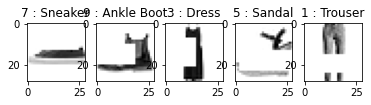

In [13]:
def image_show(train_set, num):
    for i in range(num):
      plt.subplot(1, num, i + 1, autoscale_on=True)
      plt.imshow(train_set[i][0].squeeze(), cmap=plt.cm.binary)
      plt.title(str(train_set[i][1])+" : "+output_label(train_set[i][1]))
image_show(modified_data, 5)

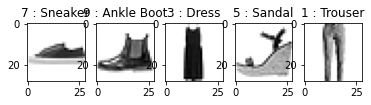

In [14]:
image_show(normal_data, 5)

In [15]:
# define dataloader
data_loader = torch.utils.data.DataLoader(train_data, batch_size=10)

batch = next(iter(data_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


# model design


In [16]:
# define model
class FashionNet(nn.Module):
    def __init__(self):
        super(FashionNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(dropout)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        logits = out
        probs = F.softmax(logits, dim=1)
        return logits, probs

# print loss


In [17]:
def plot_losses(fold, train_losses, valid_losses, learning_rate, num_epochs, batch_size):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="fold "+str(fold)+",Loss over epochs, using learning_rate =" + str(learning_rate) + ",epoch = " + str(num_epochs) + ",batch_size = " + str(batch_size),
           xlabel='Epoch',
           ylabel='Cross Entropy Loss')
    ax.legend()
    plt.tight_layout()
    fig.savefig(pj_root+"Train_Valid_Results/"+str(fold)+"_fold_loss .png", dpi=300)
    fig.show()

    # change the plot style to default
    plt.style.use('default')


def plot_acc(fold, train_acc_list, valid_acc_list, learning_rate, num_epochs, batch_size):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_losses = np.array(train_acc_list)
    valid_losses = np.array(valid_acc_list)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_losses, color='blue', label='Training accuracy')
    ax.plot(valid_losses, color='red', label='Validation accuracy')
    ax.set(title="fold "+str(fold)+",accuracy over epochs, using learning_rate ="
                 + str(learning_rate) + ",epoch = " + str(num_epochs) + ",batch_size = " + str(batch_size),
           xlabel='Epoch',
           ylabel='accuracy(%)')
    ax.legend()
    plt.tight_layout()
    fig.savefig(pj_root+"Train_Valid_Results/"+str(fold)+"_fold_acc.png", dpi=300)
    fig.show()

    # change the plot style to default
    plt.style.use('default')

# Train our network 

In [18]:
# training function
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    correct_pred = 0
    n = 0

    for X, y_true in train_loader:
        optimizer.zero_grad()

        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass
        y_hat, y_prob = model(X)
        _, predicted_labels = torch.max(y_prob, 1)


        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)
        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()
        epoch_accuracy = 100*correct_pred.float() / n

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)

    return model, optimizer, epoch_loss, epoch_accuracy

In [19]:
# validation function
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''

    model.eval()
    running_loss = 0
    correct_pred = 0
    n = 0

    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass
        y_hat, y_prob = model(X)
        _, predicted_labels = torch.max(y_prob, 1)

        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)
        n += y_true.size(0)
        correct_pred += (predicted_labels == y_true).sum()
        epoch_accuracy = 100*correct_pred.float() / n

    epoch_loss = running_loss / len(train_loader.dataset)

    return model, epoch_loss, epoch_accuracy

In [20]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device, print_interval=10):
    '''
    Function defining the entire training loop
    '''
    f = open(pj_root+"Train_Valid_Results/"+str(fold)+"_fold_log.txt", 'a')
    f.write("learning_rate =" + str(learning_rate) + ",epoch = " + str(num_epochs) + ",batch_size = " + str(batch_size))
    f.close()


    # set objects for storing metrics
    train_losses = []
    valid_losses = []
    train_acc_list = []
    valid_acc_list = []

    # Train model
    for epoch in range(0, num_epochs):
        # training
        model, optimizer, train_loss, train_acc = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_acc_list.append(train_acc)
      # print('Training process has finished. Saving trained model.')

        # validation
        with torch.no_grad():
            model, valid_loss,valid_acc = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)
            valid_acc_list.append(valid_acc)

        if epoch % print_interval == (print_interval - 1):
            torch.save(model.state_dict(), pj_root+"Train_Valid_Results/"+str(fold)+"_fold_model.pth")
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch + 1}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy(%): {train_acc:.2f}\t'
                  f'Valid accuracy(%): {valid_acc:.2f}')

            f = open(pj_root+"Train_Valid_Results/log.txt", 'a')
            f.write(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch + 1}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy(%): {train_acc:.2f}\t'
                  f'Valid accuracy(%): {valid_acc:.2f}\n')
            f.close()

    plot_losses(fold, train_losses, valid_losses, learning_rate, num_epochs, batch_size)
    plot_acc(fold, train_acc_list, valid_acc_list, learning_rate, num_epochs, batch_size)

    return model, optimizer, (train_losses, valid_losses, train_acc_list, valid_acc_list)


--------------------------------
FOLD 1
--------------------------------
16:13:35 --- Epoch: 10	Train loss: 0.2349	Valid loss: 0.0241	Train accuracy(%): 90.50	Valid accuracy(%): 91.22
16:14:51 --- Epoch: 20	Train loss: 0.1961	Valid loss: 0.0269	Train accuracy(%): 92.04	Valid accuracy(%): 91.50
16:16:06 --- Epoch: 30	Train loss: 0.1775	Valid loss: 0.0275	Train accuracy(%): 92.76	Valid accuracy(%): 91.37
16:17:21 --- Epoch: 40	Train loss: 0.1583	Valid loss: 0.0259	Train accuracy(%): 93.52	Valid accuracy(%): 92.08
16:18:35 --- Epoch: 50	Train loss: 0.1472	Valid loss: 0.0249	Train accuracy(%): 93.97	Valid accuracy(%): 92.28
16:19:50 --- Epoch: 60	Train loss: 0.1403	Valid loss: 0.0259	Train accuracy(%): 94.32	Valid accuracy(%): 92.45
16:21:05 --- Epoch: 70	Train loss: 0.1371	Valid loss: 0.0280	Train accuracy(%): 94.42	Valid accuracy(%): 91.97
16:22:20 --- Epoch: 80	Train loss: 0.1302	Valid loss: 0.0263	Train accuracy(%): 94.50	Valid accuracy(%): 92.15
16:23:35 --- Epoch: 90	Train loss: 0.12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `f

Starting testing
Accuracy for fold 6: 92 %
--------------------------------
FOLD 7
--------------------------------
17:29:47 --- Epoch: 10	Train loss: 0.2337	Valid loss: 0.0299	Train accuracy(%): 90.59	Valid accuracy(%): 89.77
17:31:03 --- Epoch: 20	Train loss: 0.1961	Valid loss: 0.0266	Train accuracy(%): 91.99	Valid accuracy(%): 91.12
17:32:20 --- Epoch: 30	Train loss: 0.1726	Valid loss: 0.0287	Train accuracy(%): 93.01	Valid accuracy(%): 90.80
17:33:36 --- Epoch: 40	Train loss: 0.1622	Valid loss: 0.0263	Train accuracy(%): 93.50	Valid accuracy(%): 91.57
17:34:53 --- Epoch: 50	Train loss: 0.1518	Valid loss: 0.0266	Train accuracy(%): 93.76	Valid accuracy(%): 92.25
17:36:10 --- Epoch: 60	Train loss: 0.1424	Valid loss: 0.0295	Train accuracy(%): 94.25	Valid accuracy(%): 91.47
17:37:28 --- Epoch: 70	Train loss: 0.1364	Valid loss: 0.0298	Train accuracy(%): 94.43	Valid accuracy(%): 91.60
17:38:45 --- Epoch: 80	Train loss: 0.1301	Valid loss: 0.0300	Train accuracy(%): 94.64	Valid accuracy(%): 91

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `f

Starting testing
Accuracy for fold 7: 91 %
--------------------------------
FOLD 8
--------------------------------
17:42:42 --- Epoch: 10	Train loss: 0.2333	Valid loss: 0.0272	Train accuracy(%): 90.63	Valid accuracy(%): 90.22
17:43:59 --- Epoch: 20	Train loss: 0.1930	Valid loss: 0.0241	Train accuracy(%): 92.18	Valid accuracy(%): 91.93
17:45:20 --- Epoch: 30	Train loss: 0.1697	Valid loss: 0.0235	Train accuracy(%): 93.06	Valid accuracy(%): 92.60
17:46:38 --- Epoch: 40	Train loss: 0.1586	Valid loss: 0.0247	Train accuracy(%): 93.54	Valid accuracy(%): 91.47
17:47:56 --- Epoch: 50	Train loss: 0.1501	Valid loss: 0.0249	Train accuracy(%): 93.83	Valid accuracy(%): 91.75
17:49:14 --- Epoch: 60	Train loss: 0.1413	Valid loss: 0.0276	Train accuracy(%): 94.22	Valid accuracy(%): 91.93
17:50:32 --- Epoch: 70	Train loss: 0.1360	Valid loss: 0.0256	Train accuracy(%): 94.29	Valid accuracy(%): 92.23
17:51:50 --- Epoch: 80	Train loss: 0.1299	Valid loss: 0.0273	Train accuracy(%): 94.70	Valid accuracy(%): 91

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `f

Starting testing
Accuracy for fold 8: 91 %
--------------------------------
FOLD 9
--------------------------------
17:55:48 --- Epoch: 10	Train loss: 0.2343	Valid loss: 0.0250	Train accuracy(%): 90.59	Valid accuracy(%): 91.50
17:57:07 --- Epoch: 20	Train loss: 0.1941	Valid loss: 0.0249	Train accuracy(%): 92.03	Valid accuracy(%): 91.78
17:58:25 --- Epoch: 30	Train loss: 0.1720	Valid loss: 0.0282	Train accuracy(%): 92.93	Valid accuracy(%): 91.32
17:59:46 --- Epoch: 40	Train loss: 0.1624	Valid loss: 0.0259	Train accuracy(%): 93.28	Valid accuracy(%): 91.65
18:01:05 --- Epoch: 50	Train loss: 0.1504	Valid loss: 0.0267	Train accuracy(%): 93.73	Valid accuracy(%): 91.87
18:02:22 --- Epoch: 60	Train loss: 0.1385	Valid loss: 0.0293	Train accuracy(%): 94.31	Valid accuracy(%): 91.82
18:03:40 --- Epoch: 70	Train loss: 0.1339	Valid loss: 0.0281	Train accuracy(%): 94.46	Valid accuracy(%): 92.27
18:04:57 --- Epoch: 80	Train loss: 0.1306	Valid loss: 0.0288	Train accuracy(%): 94.65	Valid accuracy(%): 92

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `f

Starting testing
Accuracy for fold 9: 92 %
--------------------------------
FOLD 10
--------------------------------
18:08:51 --- Epoch: 10	Train loss: 0.2314	Valid loss: 0.0245	Train accuracy(%): 90.75	Valid accuracy(%): 91.05
18:10:07 --- Epoch: 20	Train loss: 0.1938	Valid loss: 0.0222	Train accuracy(%): 92.24	Valid accuracy(%): 92.28
18:11:23 --- Epoch: 30	Train loss: 0.1727	Valid loss: 0.0240	Train accuracy(%): 93.05	Valid accuracy(%): 92.03
18:12:40 --- Epoch: 40	Train loss: 0.1596	Valid loss: 0.0221	Train accuracy(%): 93.44	Valid accuracy(%): 92.55
18:13:56 --- Epoch: 50	Train loss: 0.1490	Valid loss: 0.0241	Train accuracy(%): 93.77	Valid accuracy(%): 92.03
18:15:13 --- Epoch: 60	Train loss: 0.1406	Valid loss: 0.0236	Train accuracy(%): 94.20	Valid accuracy(%): 92.38
18:16:28 --- Epoch: 70	Train loss: 0.1320	Valid loss: 0.0278	Train accuracy(%): 94.54	Valid accuracy(%): 91.77
18:17:44 --- Epoch: 80	Train loss: 0.1305	Valid loss: 0.0249	Train accuracy(%): 94.70	Valid accuracy(%): 9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `f

Starting testing
Accuracy for fold 10: 92 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 1: 92.0 %
Fold 2: 92.25 %
Fold 3: 92.5 %
Fold 4: 92.03333282470703 %
Fold 5: 92.08333587646484 %
Fold 6: 92.41666412353516 %
Fold 7: 91.53333282470703 %
Fold 8: 91.5999984741211 %
Fold 9: 92.54999542236328 %
Fold 10: 92.53333282470703 %
Average: 92.14999389648438 %


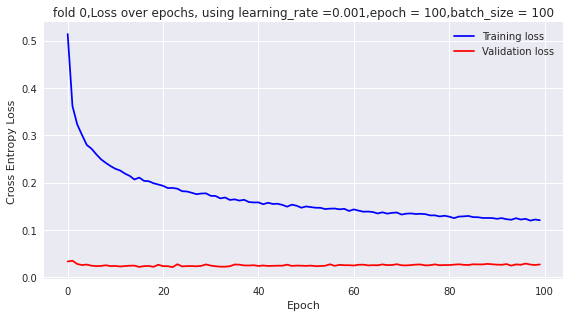

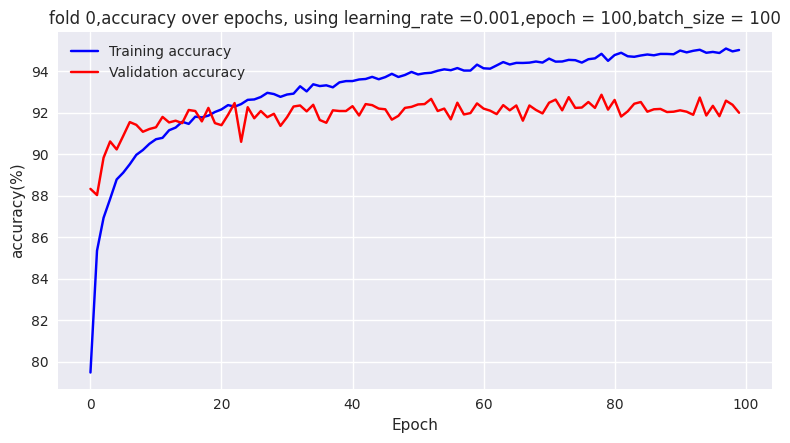

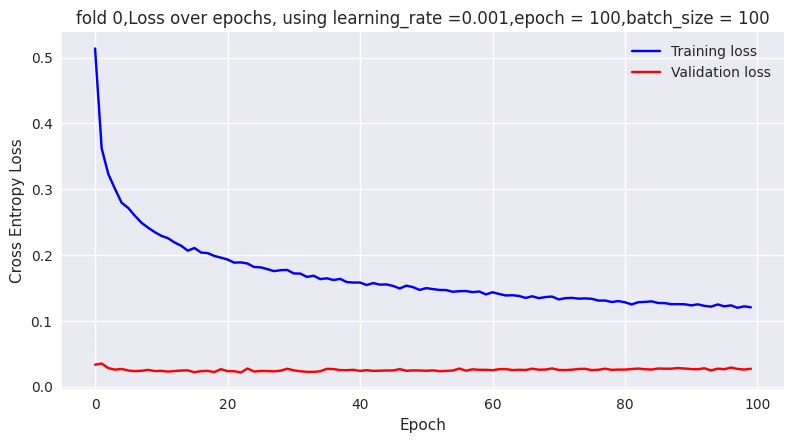

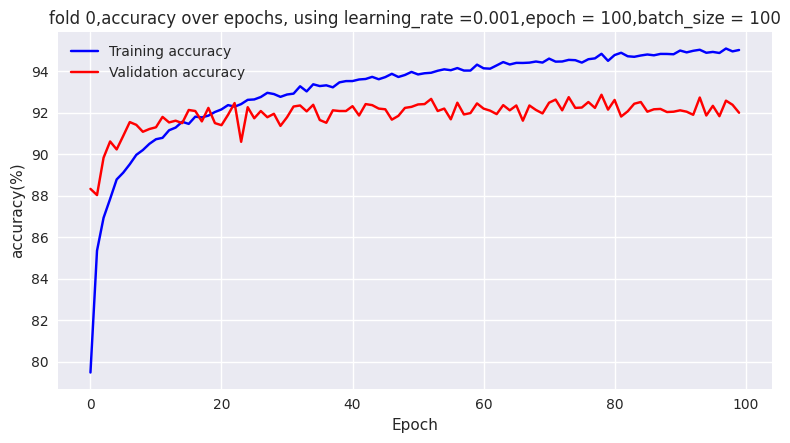

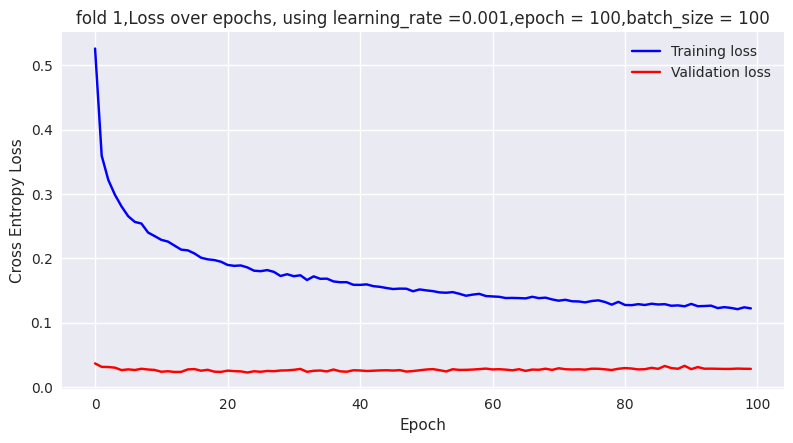

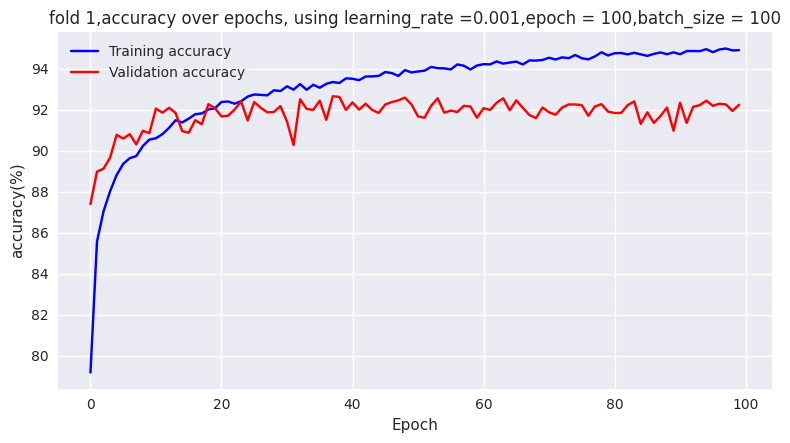

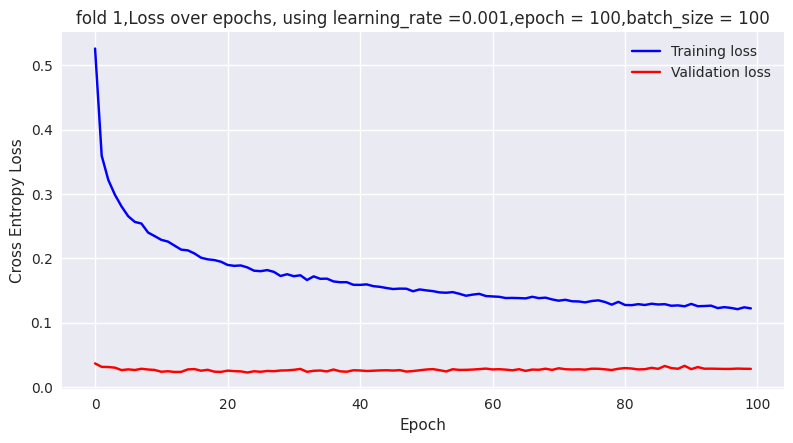

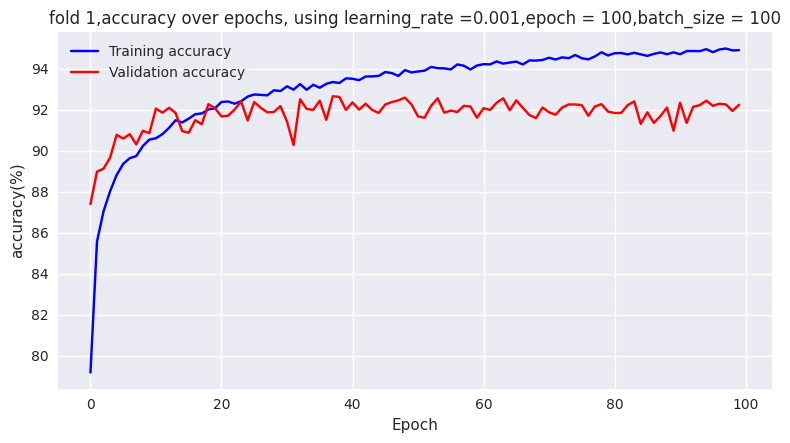

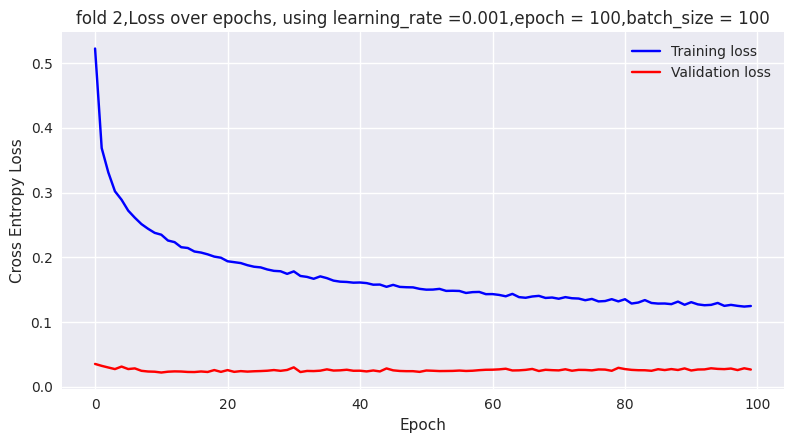

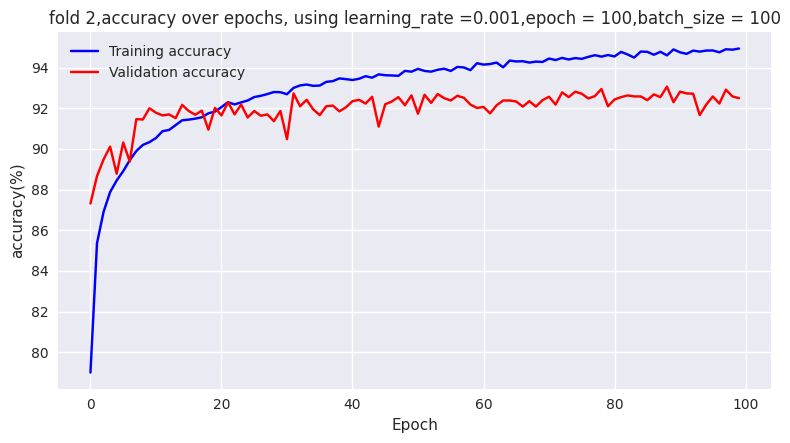

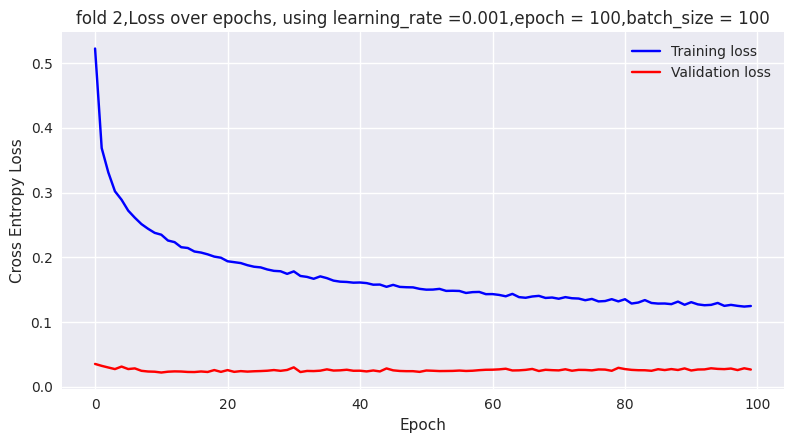

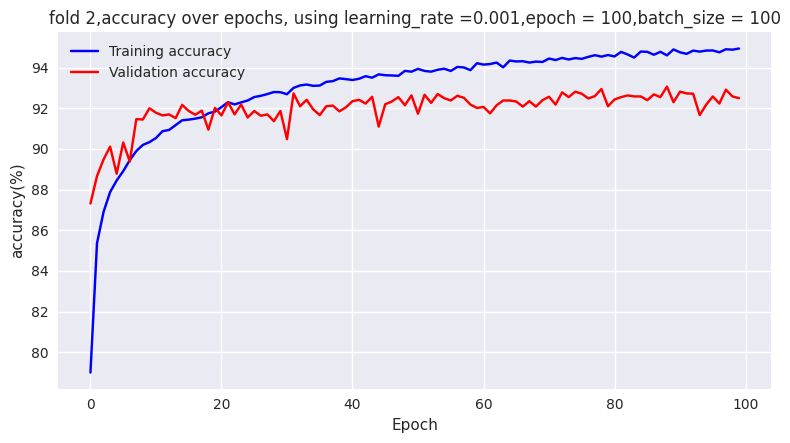

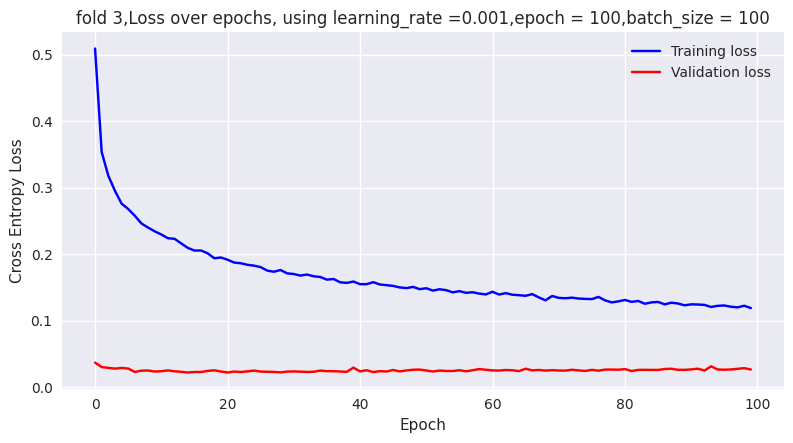

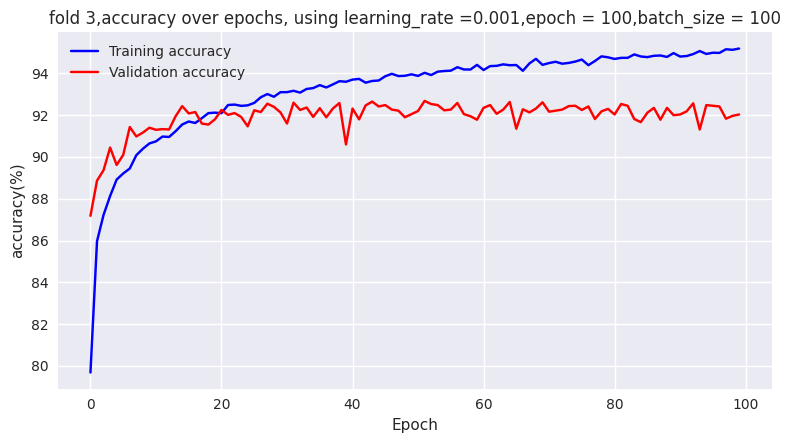

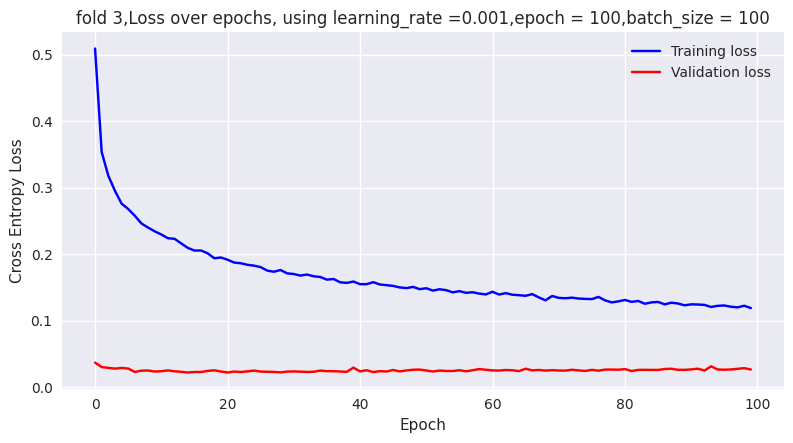

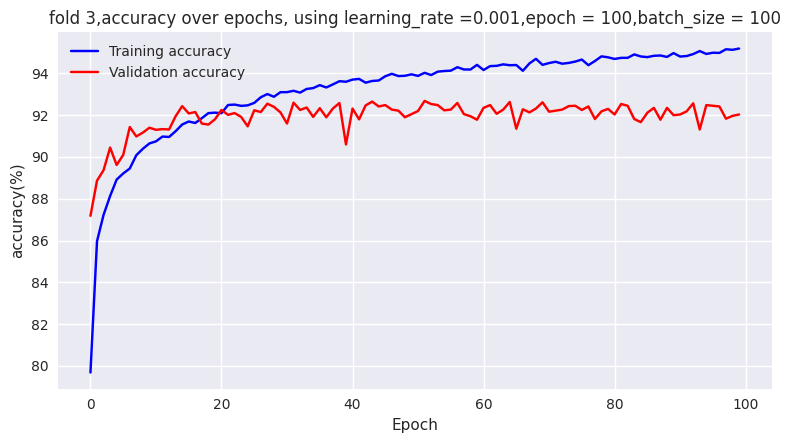

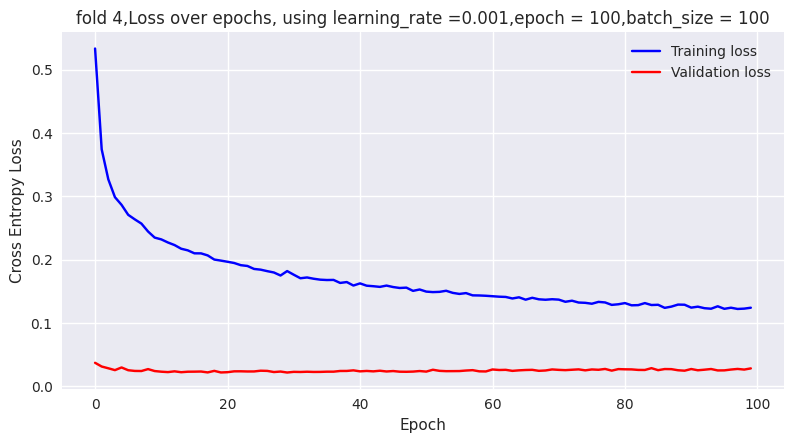

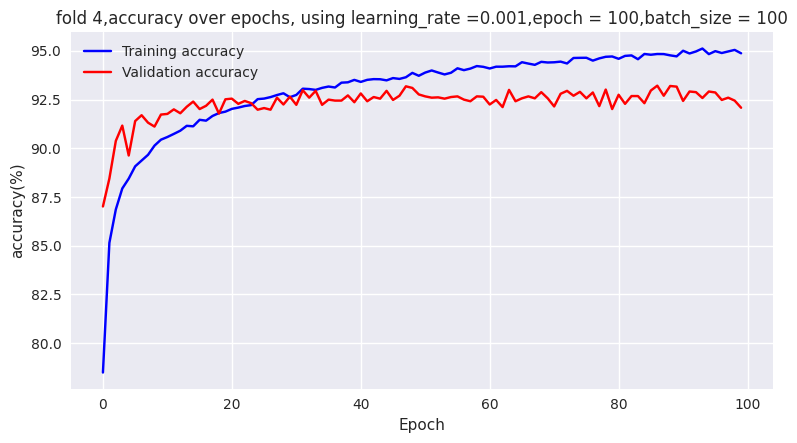

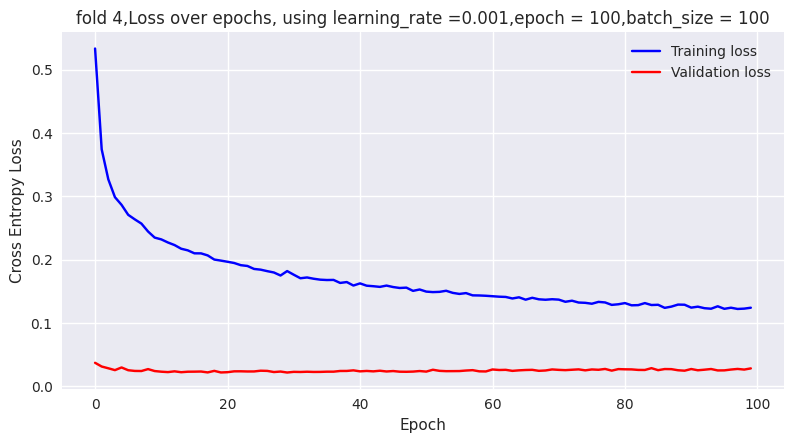

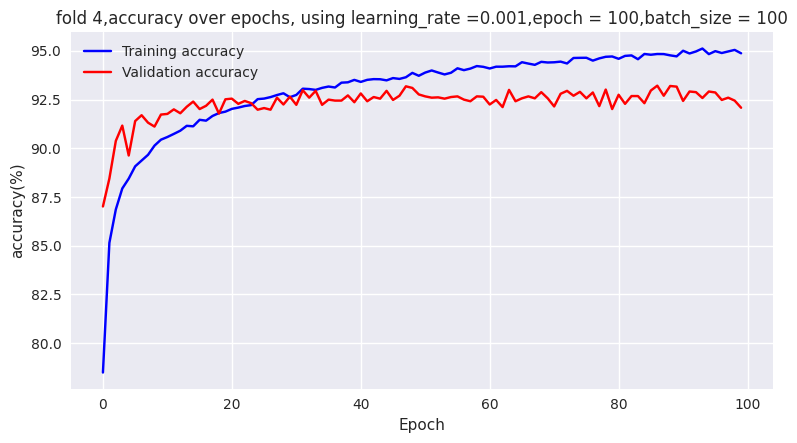

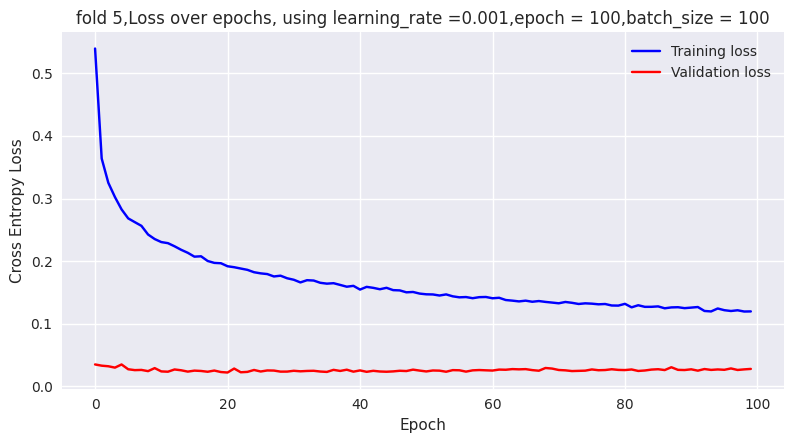

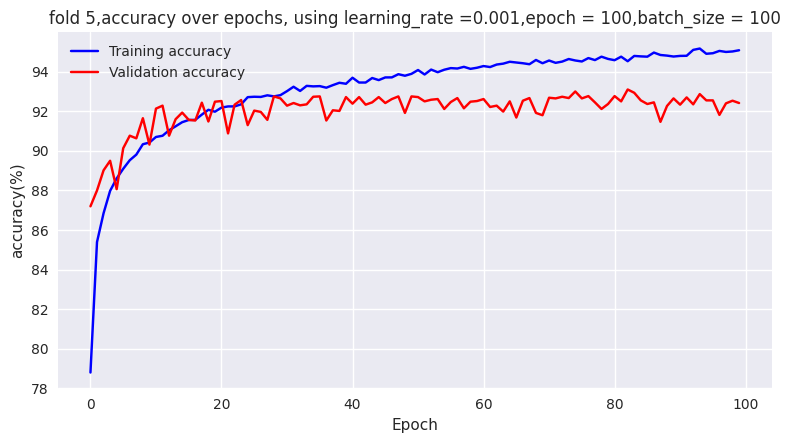

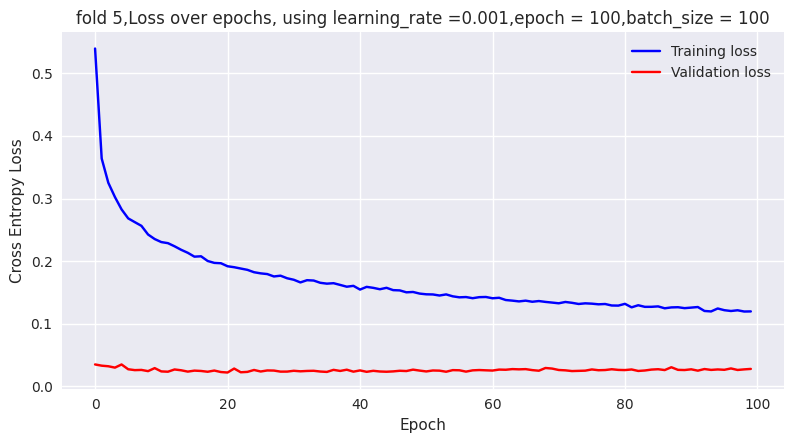

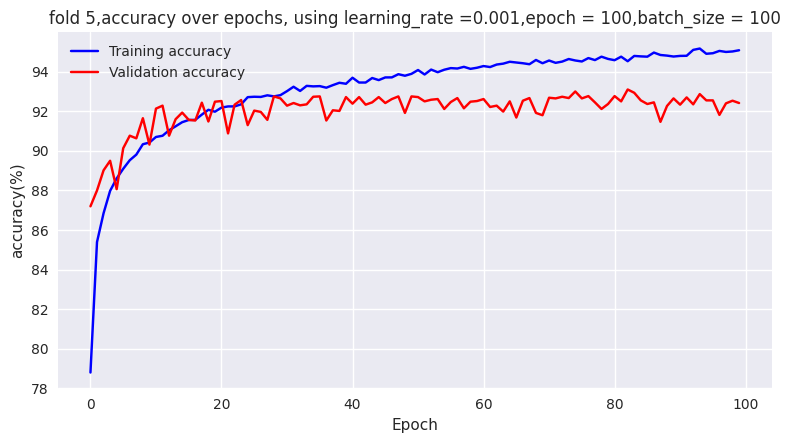

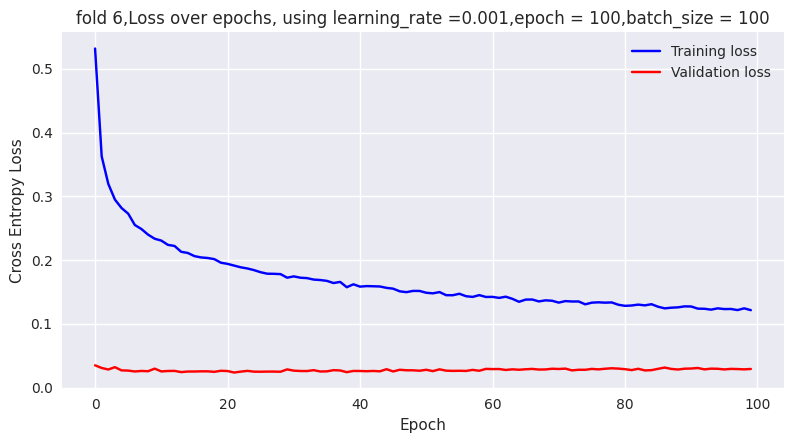

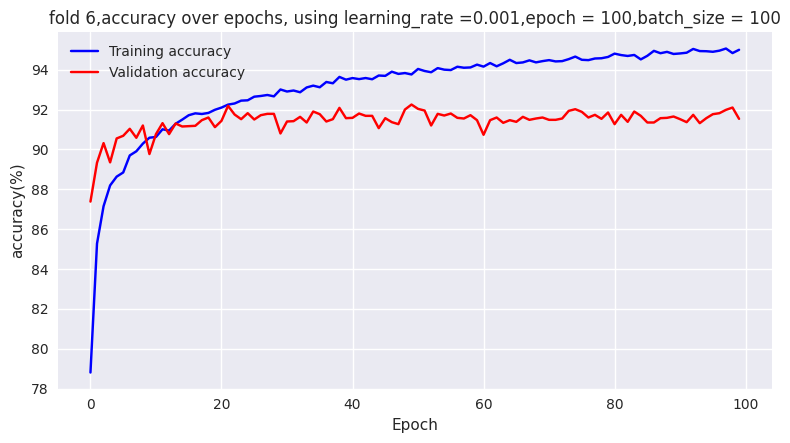

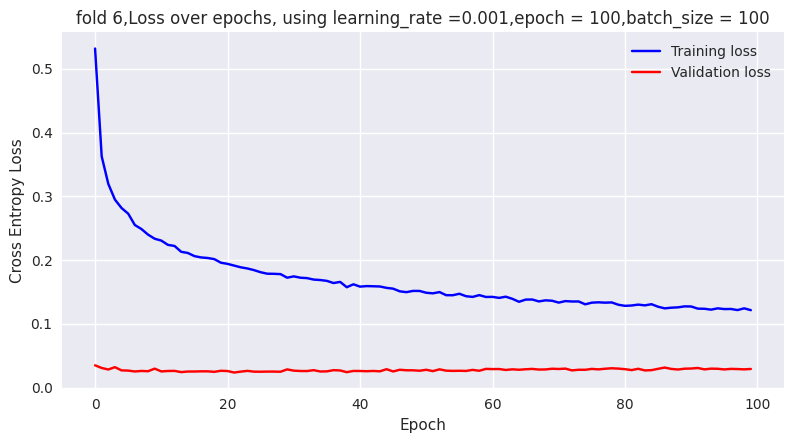

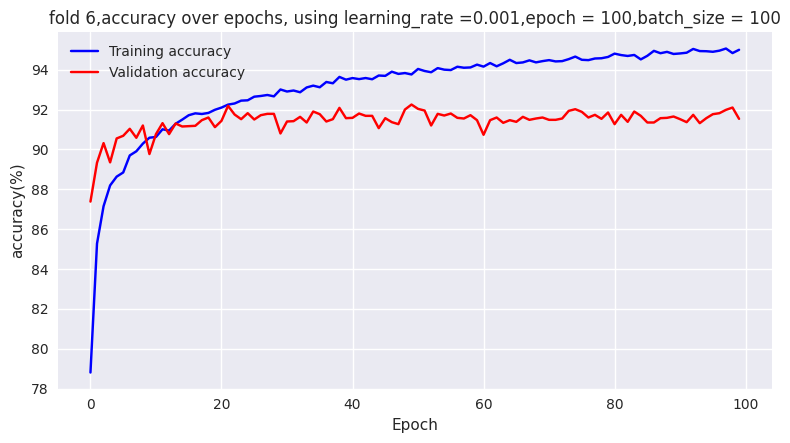

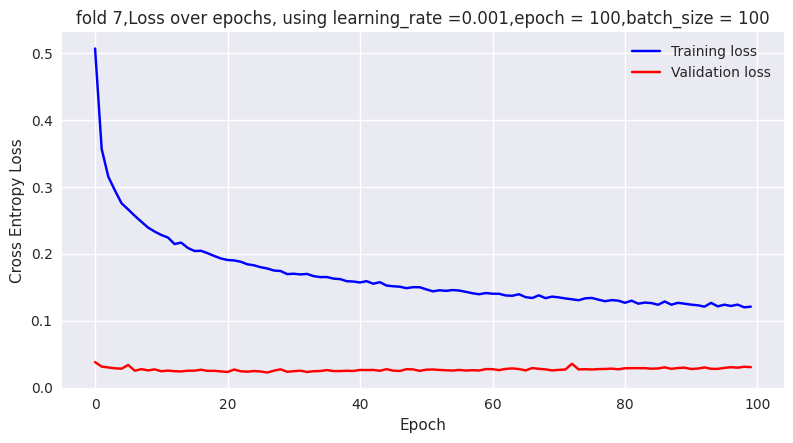

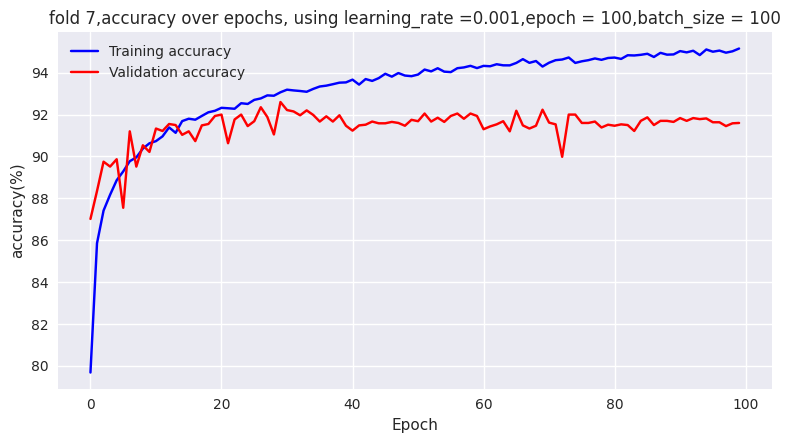

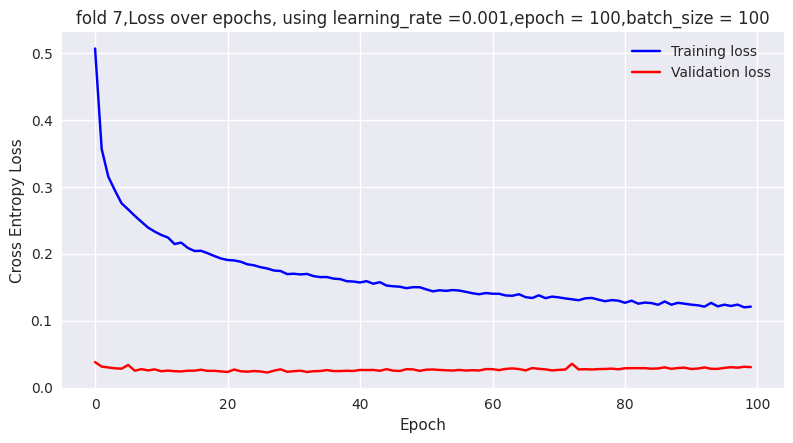

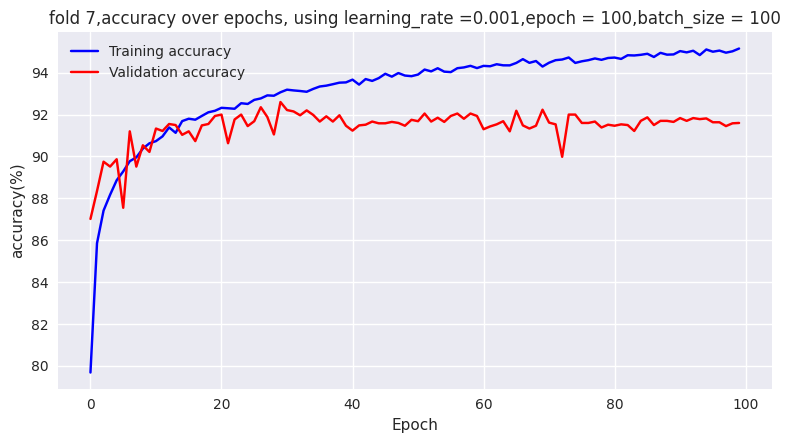

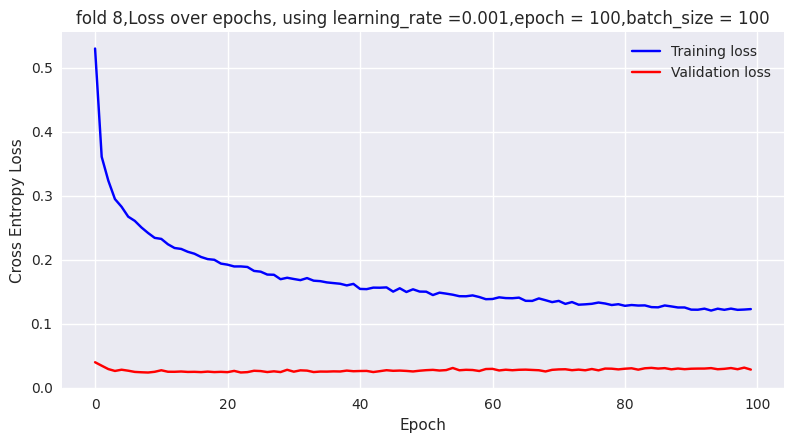

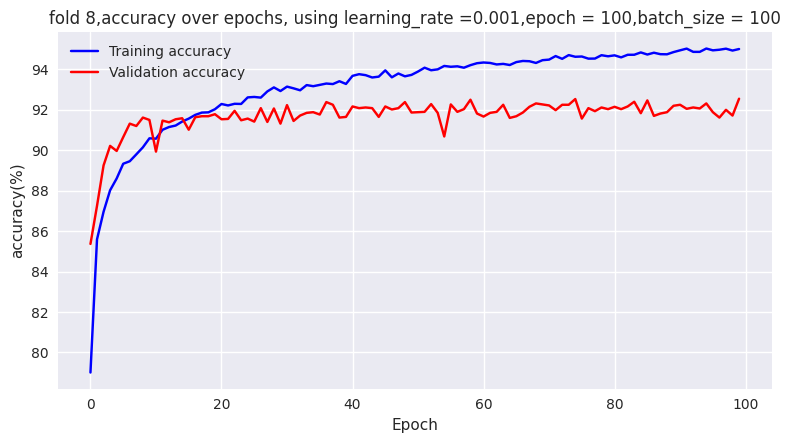

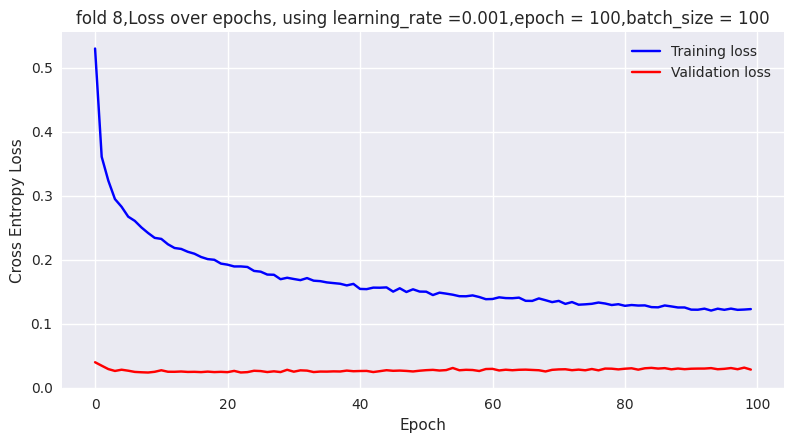

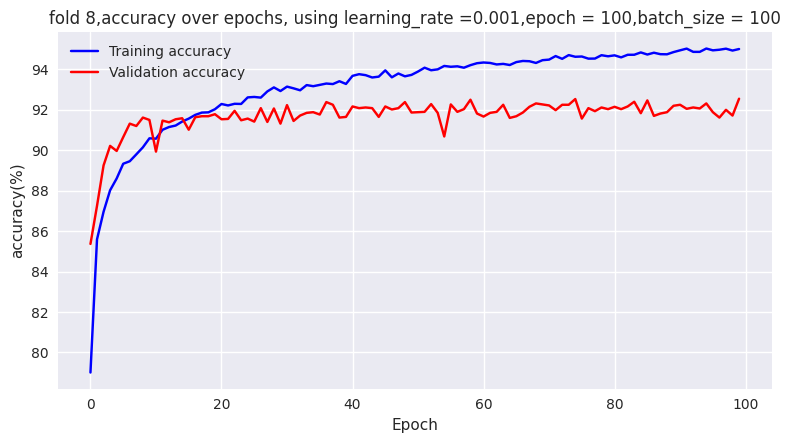

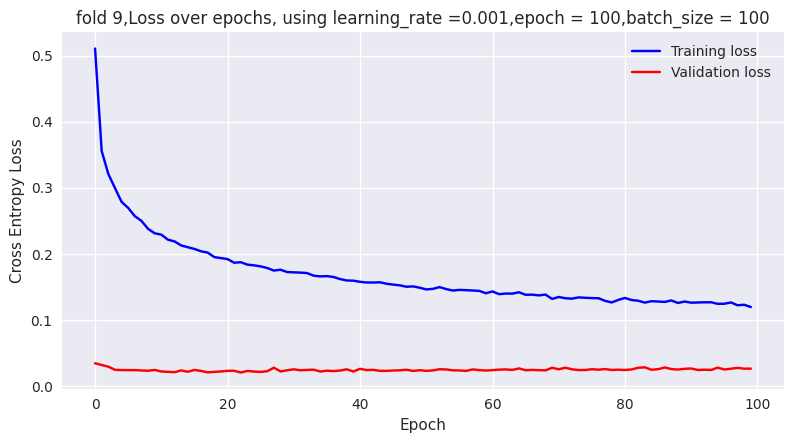

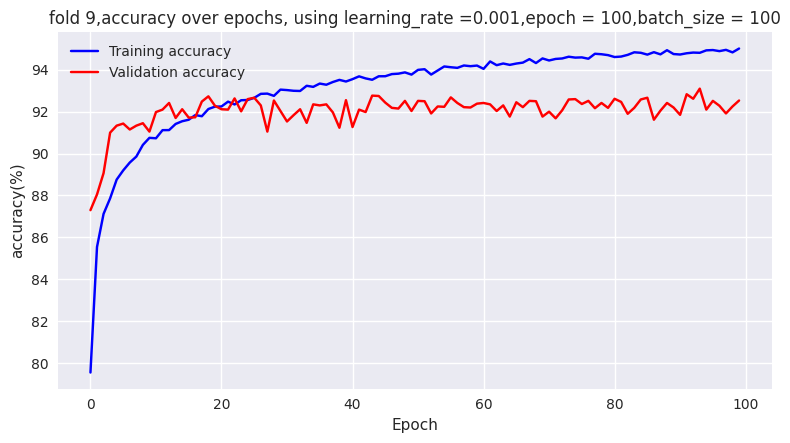

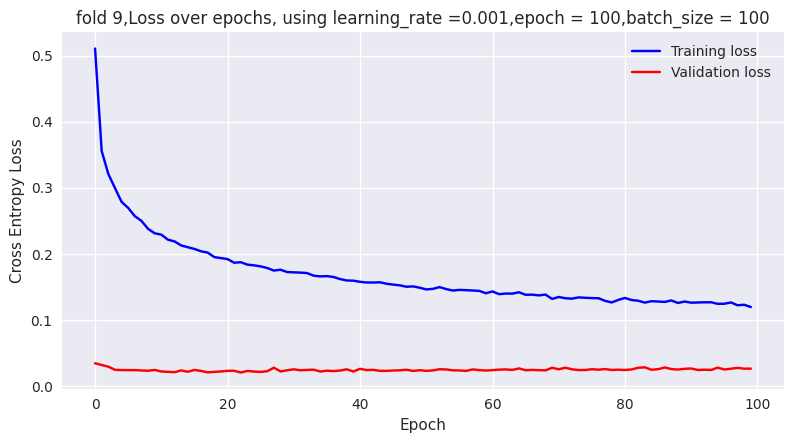

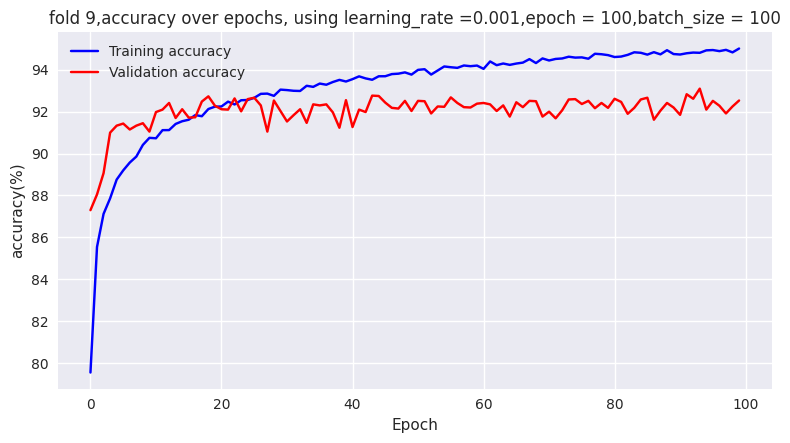

In [21]:
# main

# For fold results
results = {}
  
# Set fixed random number seed
torch.manual_seed(1576 - 1485)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)
  
# Start print
print('--------------------------------')
# K-fold Cross Validation model evaluation
for fold, (train_ids, valid_ids) in enumerate(kfold.split(modified_data)):
  
  # Print
  print(f'FOLD {fold+1}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)
  
  # Define data loaders for training and testing data in this fold
  train_loader = torch.utils.data.DataLoader(
                    modified_data, 
                    batch_size=batch_size, sampler=train_subsampler)
  valid_loader = torch.utils.data.DataLoader(
                    normal_data,
                    batch_size=batch_size, sampler=valid_subsampler)
    
    # Init the neural network
  model = FashionNet().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  model, optimizer, (train_losses, valid_losses, train_acc_list, valid_acc_list) = training_loop(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device, print_interval=10) 

  plot_losses(fold, train_losses, valid_losses, learning_rate, num_epochs, batch_size)
  plot_acc(fold, train_acc_list, valid_acc_list, learning_rate, num_epochs, batch_size)

  # Print about testing
  print('Starting testing')
  
  # Saving the model
  save_path = f'./model-fold-{fold+1}.pth'
  torch.save(model.state_dict(), save_path)

  # Evaluationfor this fold
  _, loss, accuracy = validate(valid_loader, model, criterion, device)

  # Print accuracy
  print('Accuracy for fold %d: %d %%' % (fold+1, accuracy))
  print('--------------------------------')
  results[fold] = accuracy
  
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key+1}: {value} %')
  sum += value
print(f'Average: {sum/len(results.items())} %')

In [22]:
 print(model)

FashionNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [23]:
test_data = torchvision.datasets.FashionMNIST(root=pj_root,train=False, download=True)
 


Extracting /content/gdrive/MyDrive/Data/서강전자7학기/인공지능통신/pj/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/gdrive/MyDrive/Data/서강전자7학기/인공지능통신/pj/FashionMNIST/raw




Extracting /content/gdrive/MyDrive/Data/서강전자7학기/인공지능통신/pj/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/Data/서강전자7학기/인공지능통신/pj/FashionMNIST/raw




Extracting /content/gdrive/MyDrive/Data/서강전자7학기/인공지능통신/pj/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/gdrive/MyDrive/Data/서강전자7학기/인공지능통신/pj/FashionMNIST/raw




Extracting /content/gdrive/MyDrive/Data/서강전자7학기/인공지능통신/pj/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/gdrive/MyDrive/Data/서강전자7학기/인공지능통신/pj/FashionMNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


print Confusion Matrix(예정)

In [24]:
# # main

# # For fold results
# results = {}
  
# # Set fixed random number seed
# torch.manual_seed(1576 - 1485)

# # Define the K-fold Cross Validator
# kfold = KFold(n_splits=k_folds, shuffle=True)
  
# # Start print
# print('--------------------------------')
# # K-fold Cross Validation model evaluation
# for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_data)):
  
#   # Print
#   print(f'FOLD {fold+1}')
#   print('--------------------------------')
  
#   # Sample elements randomly from a given list of ids, no replacement.
#   train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
#   valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)
  
#   # Define data loaders for training and testing data in this fold
#   train_loader = torch.utils.data.DataLoader(
#                     train_data, 
#                     batch_size=batch_size, sampler=train_subsampler)
#   valid_loader = torch.utils.data.DataLoader(
#                     valid_data,
#                     batch_size=batch_size, sampler=valid_subsampler)
    
#     # Init the neural network
#   model = FashionNet().to(device)
#   criterion = nn.CrossEntropyLoss()
#   optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#   model, optimizer, (train_losses, valid_losses, train_acc_list, valid_acc_list) = training_loop(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device, print_interval=10) 

#   plot_losses(fold, train_losses, valid_losses, learning_rate, num_epochs, batch_size)
#   plot_acc(fold, train_acc_list, valid_acc_list, learning_rate, num_epochs, batch_size)

#   # Print about testing
#   print('Starting testing')
  
#   # Saving the model
#   save_path = f'./model-fold-{fold+1}.pth'
#   torch.save(model.state_dict(), save_path)

#   # Evaluationfor this fold
#   _, loss, accuracy = validate(valid_loader, model, criterion, device)

#   # Print accuracy
#   print('Accuracy for fold %d: %d %%' % (fold+1, accuracy))
#   print('--------------------------------')
#   results[fold] = accuracy
  
# # Print fold results
# print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
# print('--------------------------------')
# sum = 0.0
# for key, value in results.items():
#   print(f'Fold {key+1}: {value} %')
#   sum += value
# print(f'Average: {sum/len(results.items())} %')